In [2]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

%matplotlib inline

# Unsupervised learning, part 1: Clustering

Unsupervised learning -- there is no 'supervisor' or 'teacher', i.e. we do not want to predict a known attribute. We rather want to 'understand' the data by either clustering or reducing dimensionality. 

## Clustering

The process of finding 'clusters' -- group the data sharing similar properties

![clustering](https://cdn-images-1.medium.com/max/1600/1*tWaaZX75oumVwBMcKN-eHA.png)

## Example 1: Houses in Storm Lake

In [724]:
# Houses in Storm Lake
import pandas as pd

df = pd.read_csv('../data/housing_stats_clean.csv')
df.head()

,Address,Listing,City,Bed,Bth,Map,LotSz,SqFt,Year,DOM_CDOM,...,OrigPrice,ListPrice,SellingPrice,SPLP,Unnamed: 21,total_baths,full_baths,three_q_baths,half_baths,q_baths
0,815 E Lakeshore Dr,44012132,Storm Lake,5,4 (4 0 0 0),",",16405.0,4010.0,1991,645/645,...,550000,299900,280000,93.36,39478,4,4,0,0,0
1,307 Lake Ave,44012256,Storm Lake,4,2 (2 0 0 0),",",14000.0,3412.0,1907,12-Dec,...,162000,162000,156000,96.30,39447,2,2,0,0,0
2,800 Meadow Ln,44012644,Storm Lake,3,3 (3 0 0 0),",",14000.0,1562.0,1981,54/54,...,217000,217000,204000,94.01,39402,3,3,0,0,0
3,1308 Poplar Ln,44012701,Storm Lake,3,3 (2 0 0 1),",",13500.0,1872.0,1977,147/147,...,174900,159500,150000,94.04,39451,3,2,0,0,1
4,1420 N Seneca St,44012791,Storm Lake,4,3 (2 0 1 0),",",8475.0,NaN,2007,120/120,...,149800,149800,158598,105.87,39524,3,2,0,1,0


In [725]:
# the list of fields
df.columns

Index(['Address', 'Listing', 'City', 'Bed', 'Bth', 'Map', 'LotSz', 'SqFt',
       'Year', 'DOM_CDOM', 'Area', 'Subdivision', 'DayofWkListed',
       'MonthListed', 'YearListed', 'Date', 'SqFt.1', 'OrigPrice', 'ListPrice',
       'SellingPrice', 'SPLP', 'Unnamed: 21', 'total_baths', 'full_baths',
       'three_q_baths', 'half_baths', 'q_baths'],
      dtype='object')

In [726]:
# there are 200 houses in total
df.shape

(200, 27)

### Let us add the coordinates for future use

In [ ]:
# Check to see how well Nominatim can convert neighborhood name to coordinates
from geopy.geocoders import Nominatim

def get_neigh_coords(inputAddress, city = 'Storm Lake', state = 'IA'):
    geolocator = Nominatim(user_agent = 'my-application')
    try:
        location = geolocator.geocode(inputAddress)
        return location.latitude,location.longitude
    except:
        pass
    try:
        location = geolocator.geocode({'street':inputAddress, 'city':city, 'state':state})
    except:
        return None,None

get_neigh_coords('815 E Lakeshore Dr')

In [ ]:
#df['coords'] = df.Address.apply(lambda x:get_coords(x)) # this will take some time to run

In [ ]:
df['lat'] = df.coords.apply(lambda x:x[0])
df['lon'] = df.coords.apply(lambda x:x[1])

### Drop NaN's

In [ ]:
df.shape, df.dropna().shape # this is how many rows of data we will lose:

In [ ]:
df.dropna().to_csv('storm_lake_houses_coords.csv') # it's OK, save and read it

### K-Means clustering by geographic location

In [3]:
df = pd.read_csv('storm_lake_houses_coords.csv')
df[['Address','lat','lon']].head()

,Address,lat,lon
0,815 E Lakeshore Dr,42.635949,-95.190106
1,307 Lake Ave,42.639569,-95.200812
2,800 Meadow Ln,42.632047,-95.242888
3,1308 Poplar Ln,42.644993,-95.184715
4,1 Colonial Cir,42.646798,-95.217970


How many clusters do we need here? The map suggests two: a bigger cluster at the North and a smaller at the West of the lake:

In [4]:
import folium
latitude, longitude = df[['lat','lon']].mean() # use the mean coordinates to center the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)
map_clusters

In [12]:
from sklearn.cluster import KMeans
n_clusters = 6 # assume there are two districts in Storm Lake
km_geo = KMeans(n_clusters = n_clusters, random_state = 1)
km_geo.fit(df[['lat','lon']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [13]:
df['cluster'] = km_geo.labels_
km_geo.labels_ # these are the cluster assignments, let's add them as a separate field to our dataframe

array([4, 1, 2, 3, 5, 3, 3, 2, 3, 2, 2, 0, 3, 2, 0, 2, 2, 5, 1, 3, 2, 2, 3,
       2, 4, 2, 2, 2, 3, 2, 3, 1, 4, 2, 3, 4, 4, 2, 1, 2, 2, 1, 0, 0, 0, 3,
       1, 2, 2, 2, 5, 5, 2, 0, 1, 3, 5, 4, 2, 0, 5, 0, 0, 5, 3, 4, 2, 1, 0,
       3, 3, 1, 3, 3, 2, 0, 3, 3, 2, 2, 1, 3, 0, 3, 5, 5, 1, 5, 0, 3, 2, 1,
       3, 0, 1, 5, 0, 3, 2, 3, 3, 3, 5, 2, 3, 5, 3, 5, 1, 2, 5, 1, 2, 0, 3,
       2, 3, 2, 3, 1, 1, 5, 3, 3, 5, 3, 3, 4, 0, 0, 0, 5, 0, 3, 2, 2, 3, 0,
       2, 0, 2, 5, 0, 3, 0, 2, 1, 3, 3, 0, 3, 3, 0, 3, 1, 0, 0, 2, 5, 0, 0], dtype=int32)

In [8]:
df.groupby('cluster')[['lat','lon']].mean()

,lat,lon
cluster,,
0,42.630896,-95.240242
1,42.650399,-95.189705
2,42.645126,-95.221718
3,42.638442,-95.199553


So, we have two clusters:
* cluster 0 -- West of the lake
* cluster 1 -- North of the lake

Let's see some houses in each cluster and the map with two cluster centers:

In [9]:
df[df.cluster == 0][['Address']].head()

,Address
2,800 Meadow Ln
7,1104 Kelvin Rd
9,804 Clover Ln
10,704 Clover Ln
13,700 Clover Lane


In [10]:
df[df.cluster == 1][['Address']].head()

,Address
3,1308 Poplar Ln
5,705 Maywood Dr
6,518 Expansion Blvd
8,1209 N Oneida St
12,1110 Lincoln Rd


In [14]:
cluster_coords = df.groupby('cluster')[['lat','lon']].mean().to_dict('records')
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

for coord in cluster_coords:
    cm = folium.Marker(
        [coord['lat'],coord['lon']],
    )
    cm.add_to(map_clusters)
    
map_clusters

### Finding the optimal number of clusters

What if two clusters is not enough? How do we determine the optimal number of clusters?

![elbow method](https://www.datascience.com/hs-fs/hubfs/Blog/introduction-to-k-means-clustering-elbow-point-example.png?width=760&height=411&name=introduction-to-k-means-clustering-elbow-point-example.png)

Let us run the previous task and compute the average distance to cluster centers for a range of cluster_no:

In [573]:
km_geo.inertia_ # Sum of squared distances of samples to their closest cluster center

0.0033603304169846347

As the number of clusters increases, inertia\_ will decrease. The optimal number of clusters is the _elbow_ point. Let us try to find it:

2 3 4 5 6 7 8 9 

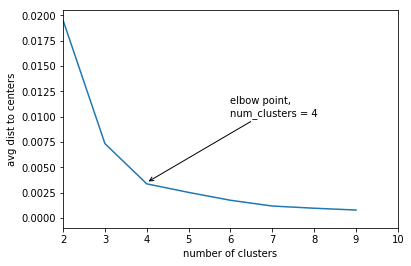

In [583]:
max_n_clusters = 10
squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(df[['lat','lon']])
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.annotate("elbow point,\nnum_clusters = 4", xy=(4, 0.0035), xytext=(6, 0.01), arrowprops={'arrowstyle':"->"})
plt.show()

### Run clustering on n_clusters = 4

In [575]:
from sklearn.cluster import KMeans
n_clusters = 4 # 4 clusters is the best
km_geo = KMeans(n_clusters = n_clusters, random_state = 1)
km_geo.fit(df[['lat','lon']])

df['cluster'] = km_geo.labels_

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)
cluster_coords = df.groupby('cluster')[['lat','lon']].mean().to_dict('records')

for coord in cluster_coords:
    cm = folium.Marker(
        [coord['lat'],coord['lon']],
    )
    cm.add_to(map_clusters)
    
map_clusters

### Clustering by house features

So far we have only looked at 2D data (lat and lon). Let us include other house features to the clustering: 

In [576]:
cols = ['Bed','SqFt','Year','SellingPrice','total_baths','LotSz','lat','lon']
df[cols].head()

,Bed,SqFt,Year,SellingPrice,total_baths,LotSz,lat,lon
0,5,4010.0,1991,280000,4,16405.0,42.635949,-95.190106
1,4,3412.0,1907,156000,2,14000.0,42.639569,-95.200812
2,3,1562.0,1981,204000,3,14000.0,42.632047,-95.242888
3,3,1872.0,1977,150000,3,13500.0,42.644993,-95.184715
4,3,2642.0,1953,215000,2,21702.0,42.646798,-95.217970


We need to find optimal number of clusters again. (BTW, why?) 

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

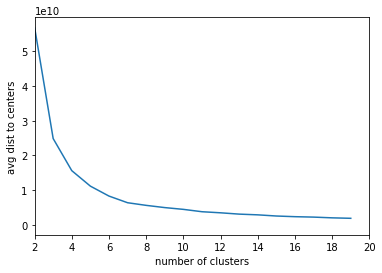

In [577]:
# How many clusters do we need? 

max_n_clusters = 20
squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(df[cols])
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.show()

In [578]:
km = KMeans(n_clusters = 7, random_state = 0).fit(df[cols])
km.fit(df[cols])

df['cluster'] = km.labels_

df.groupby('cluster')[cols].mean().sort_values(by='SellingPrice')

,SqFt,Year,SellingPrice,total_baths,LotSz,lat,lon
cluster,,,,,,,
0,1673.145833,1968.333333,154928.125000,2.562500,11697.354167,42.645570,-95.208571
5,1836.552632,1974.236842,168957.894737,2.684211,11301.631579,42.643729,-95.211062
3,1973.904762,1977.761905,184822.904762,3.047619,12464.428571,42.639276,-95.213579
2,1959.181818,1973.818182,199297.727273,2.909091,14764.090909,42.639461,-95.224773
6,1752.294118,1983.705882,222011.764706,2.705882,14080.176471,42.641082,-95.214030
1,2355.818182,1974.272727,255590.909091,3.090909,16301.818182,42.633877,-95.222969
4,2300.500000,1985.000000,286750.000000,2.750000,14200.250000,42.633645,-95.219361


In [580]:
cluster_descs = [
    "cheapest eldest houses, smallest number of bathrooms",
    "largest houses built in approx. 1974",
    "average houses",
    "good number of bathrooms, otherwise average, cheaper",
    "most expensive houses and the newest",
    "cheaper houses, smallest lot size",
    "average newer houses"
]

In [581]:
colors = [
    'red',
    'blue',
    'green',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'gray',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

for house in df.to_dict('records'):
    label_text = "cluster: %d, %s"%(house['cluster'],cluster_descs[house['cluster']])
    label = folium.Popup(label_text, parse_html=True)
    
    cm = folium.Marker(
        [house['lat'],house['lon']],
        popup = label,
        icon=folium.Icon(color=colors[house['cluster']]),
    )
    cm.add_to(map_clusters)
    
    legend_html = '''
     <div style="position: fixed; bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;">
     &nbsp; Cluster 0 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:red"></i><br>
     &nbsp; Cluster 1 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:blue"></i><br>
     &nbsp; Cluster 2 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:green"></i><br>
     &nbsp; Cluster 3 &nbsp; <i class="fa fa-map-marker fa-2x:" style="color:darkred"></i><br>

    </div>
     '''
map_clusters.get_root().html.add_child(folium.Element(legend_html))
    
map_clusters

### Scaling/normalize the data

Note that the data in the fields varies by several orders of magnitude. The clustering algorithm will optimize lot size before number of bedrooms.

To mitigate the problem, let us scale the data. There are a couple methods to do this.

#### Method 1. MinMaxScaler:
$X_{norm} = \frac{X-min(X)}{max(X)-min(X)}$

#### Method 2. StandardScaler:

$Z_X = \frac{X-\mu_X}{\sigma_X}$

$var(X) = \frac{(X-\mu_X)^2}{N}$

$\sigma_X = \sqrt{ var(X)}$

Both methods are implemented in sklearn.preprocessing library:

```python
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
```

In [648]:
df[cols].head()

,Bed,SqFt,Year,SellingPrice,total_baths,LotSz,lat,lon
0,5,4010.0,1991,280000,4,16405.0,42.635949,-95.190106
1,4,3412.0,1907,156000,2,14000.0,42.639569,-95.200812
2,3,1562.0,1981,204000,3,14000.0,42.632047,-95.242888
3,3,1872.0,1977,150000,3,13500.0,42.644993,-95.184715
4,3,2642.0,1953,215000,2,21702.0,42.646798,-95.217970


In [649]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df[cols])

/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [652]:
X[0,:]

array([ 1.84314812,  3.86385522,  0.66248668,  2.82164187,  1.91776503,
        0.83425374, -0.77504613,  1.18353017])

### Data distribution before and after scaling

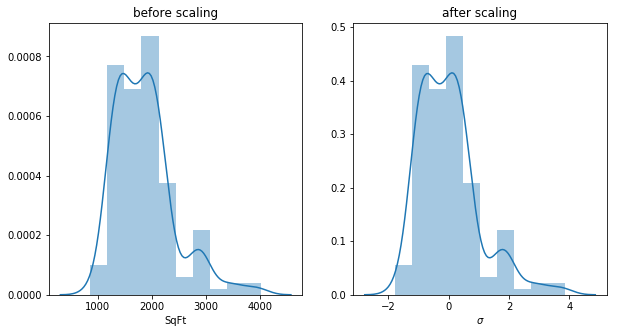

In [657]:
import seaborn as sns # seaborn is a visualization library
plt.figure(figsize = (10,5)) # create a figure of 10x5 inches
ax1 = plt.subplot(121) # create a subplot, there will be 1 row, 2 columns, and this is the 1st subplot, hence 121
ax1.set_title('before scaling')
sns.distplot(df.SqFt, ax = ax1, bins = 10) # draw df.SqFt distribution on subplot ax1
#sns.distplot(df.Year, ax = ax1, bins = 10)
ax2 = plt.subplot(122) # create a subplot, there will be 1 row, 2 columns, and this is the 2nd subplot, hence 122
ax2.set_title('after scaling')
ax2.set_xlabel('$\sigma$')
sns.distplot(X[:,1], ax = ax2, bins = 10)
#sns.distplot(X[:,2], ax = ax2, bins = 10)

### MinMaxScaler

Try to scale your data with MinMaxScaler and visualize the distributions

/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


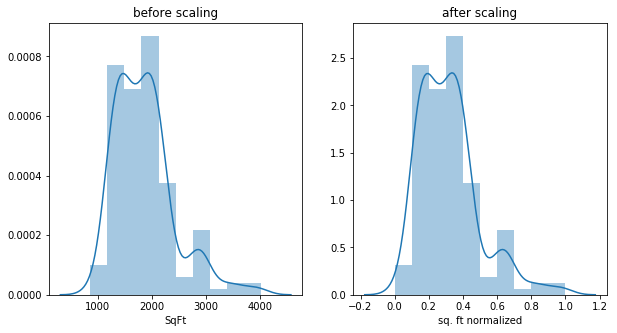

In [660]:
from sklearn.preprocessing import MinMaxScaler
X2 = MinMaxScaler().fit_transform(df[cols])

import seaborn as sns # seaborn is a visualization library
plt.figure(figsize = (10,5)) # create a figure of 10x5 inches
ax1 = plt.subplot(121) # create a subplot, there will be 1 row, 2 columns, and this is the 1st subplot, hence 121
ax1.set_title('before scaling')
sns.distplot(df.SqFt, ax = ax1, bins = 10) # draw df.SqFt distribution on subplot ax1
#sns.distplot(df.Year, ax = ax1, bins = 10)
ax2 = plt.subplot(122) # create a subplot, there will be 1 row, 2 columns, and this is the 2nd subplot, hence 122
ax2.set_title('after scaling')
ax2.set_xlabel('sq. ft normalized')
sns.distplot(X2[:,1], ax = ax2, bins = 10)
#sns.distplot(X[:,2], ax = ax2, bins = 10)

### Back to clustering

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

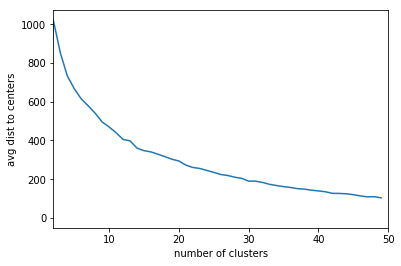

In [661]:
# How many clusters do we need? 

max_n_clusters = 50
squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X)
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.show()

In [662]:
# It looks like the data calls for at least ten clusters:

km = KMeans(n_clusters = 10, random_state = 0).fit(X)
km.fit(df[cols])

df['cluster'] = km.labels_

df.groupby('cluster')[cols].mean().sort_values(by='SellingPrice')

,SqFt,Year,SellingPrice,total_baths,LotSz,lat,lon
cluster,,,,,,,
0,1682.756098,1966.365854,154076.829268,2.512195,11974.560976,42.644916,-95.210050
4,1785.703704,1971.888889,163918.518519,2.629630,11152.518519,42.645709,-95.206137
9,1829.052632,1980.000000,173263.157895,2.842105,11203.157895,42.642334,-95.215622
2,1979.650000,1977.600000,185164.050000,3.050000,12387.650000,42.639690,-95.212116
7,1959.181818,1973.818182,199297.727273,2.909091,14764.090909,42.639461,-95.224773
1,1798.700000,1989.400000,216500.000000,2.800000,14071.700000,42.642138,-95.214546
8,1686.000000,1975.571429,229885.714286,2.571429,14092.285714,42.639574,-95.213294
6,2114.666667,1968.833333,249500.000000,3.000000,14588.666667,42.633652,-95.218823
3,2645.200000,1980.800000,262900.000000,3.200000,18357.600000,42.634147,-95.227944


Interestingly enough, the most expensive houses are neither the largest, the newest, etc. Let's see what is special about them:

In [663]:
df[df.cluster == 5]

,Unnamed: 0,Address,Listing,City,Bed,Bth,Map,LotSz,SqFt,Year,...,Unnamed: 21,total_baths,full_baths,three_q_baths,half_baths,q_baths,coords,lat,lon,cluster
0,0,815 E Lakeshore Dr,44012132,Storm Lake,5,4 (4 0 0 0),",",16405.0,4010.0,1991,...,39478,4,4,0,0,0,"(42.6359485019541, -95.1901057042011)",42.635949,-95.190106,5
16,20,701 Prairie Ln,44014513,Storm Lake,5,3 (3 0 0 0),",",15744.0,1878.0,2008,...,40043,3,3,0,0,0,"(42.631797, -95.243925)",42.631797,-95.243925,5
94,120,502 Lakeshore Dr,44017178,Storm Lake,3,2 (2 0 0 0),",",7152.0,2170.0,1979,...,42171,2,2,0,0,0,"(42.6386624328948, -95.2071362206583)",42.638662,-95.207136,5
112,139,1009 Emerald Dr,44017711,Storm Lake,3,2 (2 0 0 0),",",17500.0,1144.0,1962,...,42224,2,2,0,0,0,"(42.6281717613031, -95.2362776022763)",42.628172,-95.236278,5


In [664]:
def show_cluster(cluster_no):
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)
    house_coords = df[df.cluster == cluster_no][['lat','lon','SellingPrice']].to_dict('records')

    for coord in house_coords:
        label_text = "Price: %d"%(coord['SellingPrice'])
        label = folium.Popup(label_text, parse_html=True)

        cm = folium.Marker(
            [coord['lat'],coord['lon']],
            popup = label,
        )
        cm.add_to(map_clusters)

    return map_clusters
    
show_cluster(5)

In [300]:
# The cheapest houses:
show_cluster(0)

## Employees at Storm Lake Tyson Plant

![Tyson, Storm Lake](https://dehayf5mhw1h7.cloudfront.net/wp-content/uploads/sites/304/2017/06/06114527/tyson-storm-lake.jpg)

### Data preparation

In [665]:
%ls ../data/tyson_active.csv

../data/tyson_active.csv


In [666]:
df_tyson = pd.read_csv('../data/tyson_active.csv')
df_tyson.head()

,Dept,Position,Age,Job title,Org Text,Org.unit,Supv,Gen.,Hire Date,LOS,Ethnic Text,ESgrp
0,531B,11072901,43,Frzr Warehouse,Storm Lake Loadout #1 (B),10253799,Ryan M Bailey,M,7/24/2007,10,Hispanic or Latino,10
1,726,11243198,39,No Jobber,Storm Lake Bone Cannon (A),10253856,Abel Saengchanpheng,F,3/9/2006,11,Hispanic or Latino,10
2,923,11246372,61,Whiz Belly,Storm Lake Commodity Bellies (B),10253795,Josh M Zimmer,F,9/21/2015,2,Asian (NHL),10
3,407,11308525,37,Maintenance Generalist Cl,Storm Lake Maint Cold Side N2 (B),11201789,Robert Yearicks,M,5/1/2017,0,White (NHL),10
4,965,11025873,35,No Jobber,Storm Lake Loin Boning (B),10251640,Amphone Keopaseuth,M,6/26/2017,0,Black or African American (NHL),10


In [309]:
df_tyson.shape

(2007, 12)

In [667]:
cols = ['Age ','Gen.','LOS','Ethnic Text']
df_tyson[cols].head()

,Age,Gen.,LOS,Ethnic Text
0,43,M,10,Hispanic or Latino
1,39,F,11,Hispanic or Latino
2,61,F,2,Asian (NHL)
3,37,M,0,White (NHL)
4,35,M,0,Black or African American (NHL)


In [316]:
df_ethnic = pd.get_dummies(df_tyson['Ethnic Text'])
df_ethnic.head()

,Asian (NHL),Black or African American (NHL),Hispanic or Latino,Native American/Alaskan (NHL),Native Hawaiian or other Pacific Islander (NHL),Two or more races (NHL),White (NHL)
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0


In [668]:
df_tyson2 = pd.concat([df_tyson[cols],df_ethnic],axis  = 1)
df_tyson2.drop('Ethnic Text', axis = 1, inplace = True)
df_tyson2.head()

,Age,Gen.,LOS,Asian (NHL),Black or African American (NHL),Hispanic or Latino,Native American/Alaskan (NHL),Native Hawaiian or other Pacific Islander (NHL),Two or more races (NHL),White (NHL)
0,43,M,10,0,0,1,0,0,0,0
1,39,F,11,0,0,1,0,0,0,0
2,61,F,2,1,0,0,0,0,0,0
3,37,M,0,0,0,0,0,0,0,1
4,35,M,0,0,1,0,0,0,0,0


In [324]:
# now, replace Gen. with boolean field Male
df_tyson2['Male'] = (df_tyson2['Gen.'] == 'M')
df_tyson2.head()

,Age,Gen.,LOS,Asian (NHL),Black or African American (NHL),Hispanic or Latino,Native American/Alaskan (NHL),Native Hawaiian or other Pacific Islander (NHL),Two or more races (NHL),White (NHL),Male
0,43,M,10,0,0,1,0,0,0,0,True
1,39,F,11,0,0,1,0,0,0,0,False
2,61,F,2,1,0,0,0,0,0,0,False
3,37,M,0,0,0,0,0,0,0,1,True
4,35,M,0,0,1,0,0,0,0,0,True


### Clustering


In [ ]:
# DIY
# 1. Decide which columns you exclude from clustering (use drop(['col'], axis = 1))
# 2. Decide how many clusters you will need
# 3. Run clustering and group by cluster no.
# 4. Let's see what the clusters are

In [701]:
df_tyson2.drop('Gen.', axis = 1, inplace = True)
df_tyson2.head()

,Age,LOS,Asian (NHL),Black or African American (NHL),Hispanic or Latino,Native American/Alaskan (NHL),Native Hawaiian or other Pacific Islander (NHL),Two or more races (NHL),White (NHL)
0,43,10,0,0,1,0,0,0,0
1,39,11,0,0,1,0,0,0,0
2,61,2,1,0,0,0,0,0,0
3,37,0,0,0,0,0,0,0,1
4,35,0,0,1,0,0,0,0,0


2 

/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

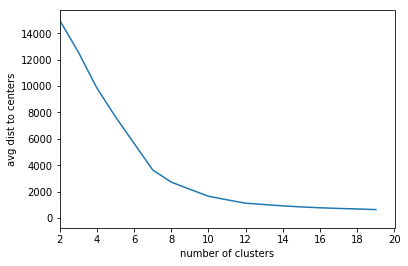

In [702]:
X = StandardScaler().fit_transform(df_tyson2)

max_n_clusters = 20
squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X)
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.show()

In [705]:
kmeans = KMeans(n_clusters = 7, random_state = 0).fit(X)
df_tyson2['cluster'] = kmeans.labels_
df_tyson2.head()

,Age,LOS,Asian (NHL),Black or African American (NHL),Hispanic or Latino,Native American/Alaskan (NHL),Native Hawaiian or other Pacific Islander (NHL),Two or more races (NHL),White (NHL),cluster
0,43,10,0,0,1,0,0,0,0,0
1,39,11,0,0,1,0,0,0,0,0
2,61,2,1,0,0,0,0,0,0,2
3,37,0,0,0,0,0,0,0,1,3
4,35,0,0,1,0,0,0,0,0,1


In [708]:
df_tyson2.groupby('cluster').mean().sort_values(by='LOS')

,Age,LOS,Asian (NHL),Black or African American (NHL),Hispanic or Latino,Native American/Alaskan (NHL),Native Hawaiian or other Pacific Islander (NHL),Two or more races (NHL),White (NHL)
cluster,,,,,,,,,
6,62.000000,0.000000,0,0,0,1,0,0,0
5,24.666667,1.333333,0,0,0,0,0,1,0
4,31.059259,1.362963,0,0,0,0,1,0,0
1,35.320225,2.573034,0,1,0,0,0,0,0
0,40.329694,7.075328,0,0,1,0,0,0,0
2,39.233564,7.437716,1,0,0,0,0,0,0
3,44.403061,13.678571,0,0,0,0,0,0,1


# MNIST Dataset

In [587]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/opt/anaconda3/envs/jh/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [697]:
mnist.data.shape

(70000, 784)

Note that this data also contains targets, so this can be used for supervised learning.

In [698]:
mnist.target[0] # this is what the first image is of

0.0

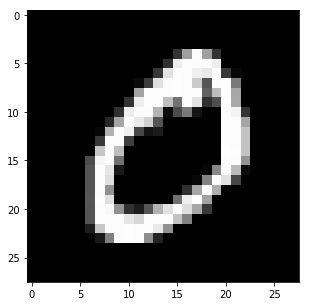

In [709]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(mnist_no = 0):
    plt.figure(figsize = (5,5))
    plt.imshow(mnist.data[mnist_no,:].reshape([28,28]), cmap = plt.cm.gray)
    plt.show()
    
show_image()

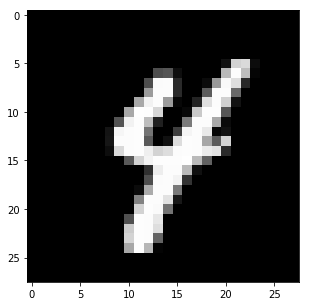

In [711]:
show_image(30500)

In [596]:
# this is what the data looks like:
mnist.data[0,:]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 159, 253,
       159,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238,
       252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

### KMeans clustering on MNIST

In [692]:
# there is too much data (70K rows)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.995, random_state=42)
X_train.shape

(350, 784)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

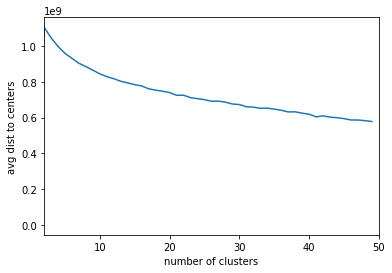

In [693]:
# How many clusters do we need? 

max_n_clusters = 50
squared_distance = np.zeros(max_n_clusters)
for k in range(2,max_n_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X_train)
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(squared_distance)
plt.xlim((2,max_n_clusters))
plt.xlabel('number of clusters')
plt.ylabel('avg dist to centers')
plt.show()

At this time, let us use 10% of our data:

In [721]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.9, random_state=0) # use 10% of data
kmeans = KMeans(n_clusters = 25, random_state = 0).fit(X_train) # find 20 clusters (change this number)
y_pred = kmeans.predict(X_train) # store cluster numbers in y_pred

* X_train -- source data
* y_pred -- predicted clusters
* y_train -- decoded images, i.e. written numbers

In [714]:
X_train.shape, y_train.shape, y_pred.shape

((7000, 784), (7000,), (7000,))

In [715]:
X_train[y_pred == 0].shape # the number of images in cluster 0

(393, 784)

In [716]:
X_train[y_pred == 0].mean(axis = 0).shape # the average image in cluster 0

(784,)

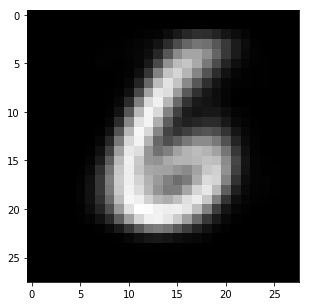

In [719]:
# visualize the average image in cluster 0
plt.figure(figsize = [5,5])
plt.imshow(X_train[y_pred == 2].mean(axis = 0).reshape([28,28]), cmap = plt.cm.gray)
plt.show()

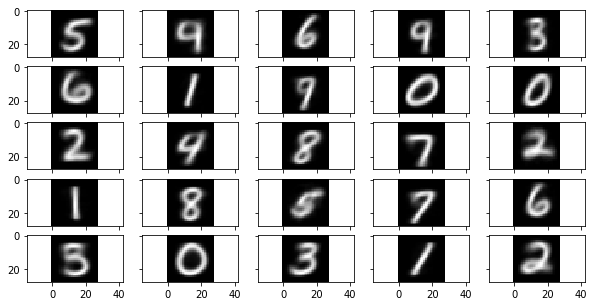

In [722]:
# visualize all 20 clusters
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (10,5))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(X_train[y_pred == i*5+j].mean(axis = 0).reshape([28,28]), cmap = plt.cm.gray)

# Appendix

## min, max, mean, std, argmin, and argmax

In [539]:
import numpy as np
arr = np.random.normal(0,1,20)
arr

array([ 0.95726541,  0.41213328,  0.35650127,  0.09724474,  0.39389953,
       -0.46877882, -0.99022406,  0.19896875,  1.82134278,  0.691666  ,
       -0.81024035,  1.02144997, -0.1949097 ,  0.79553737,  1.32368595,
        0.91798623, -0.5846606 , -0.14656039, -0.21030843,  0.07780368])

In [540]:
np.min(arr), np.max(arr), np.mean(arr), np.std(arr)

(-0.99022405673779257,
 1.821342782912563,
 0.28299013121032413,
 0.71382699431225805)

In [541]:
np.argmin(arr), np.argmax(arr)

(6, 8)

In [543]:
arr[np.argmax(arr)]

1.821342782912563

## 2D arrays

In [ ]:
arr = np.random.normal(0,1,[10,100])
arr

In [548]:
np.min(arr), np.max(arr)

(-3.83151146547053, 2.8913144766583132)

In [551]:
np.min(arr, axis = 1)

array([-2.30385111, -2.59650251, -2.59848767, -2.48792684, -1.86163687,
       -2.45346129, -1.91167317, -3.33795865, -3.83151147, -1.82912309])

In [553]:
np.argmin(arr)

894

In [556]:
arr.reshape([-1])[np.argmin(arr)] # useless, we have np.min(arr)!

-3.83151146547053

In [558]:
np.argmin(arr,axis = 1)

array([47, 39, 48, 95, 92, 41, 20,  4, 94, 27])

## Unravel_index -- convert flattened index to index

In [560]:
np.unravel_index(894, [10,100])

(8, 94)

In [562]:
np.unravel_index(np.argmin(arr), arr.shape)

(8, 94)

## Maximum and minimum function

In [ ]:
arr1 = np.random.normal(0,1,[100,10])
arr2 = np.random.normal(0,1,[100,10])

np.minimum(arr1,arr2)